# Explore Tara Geographically

In [1]:
from importlib import reload

import numpy as np
from datetime import datetime, time
import random 

import pandas
import geopandas
import seaborn as sns
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy
import corner

from oceancolor.tara import io as tara_io
from oceancolor.ph import pigments
from oceancolor.utils import cat_utils

from cnmf.oceanography import iops
from cnmf import zhu_nmf as nmf
from cnmf import io as cnmf_io

In [2]:
%matplotlib ipympl

In [3]:
tformM = ccrs.Mollweide()
tformP = ccrs.PlateCarree()

# Load

## Load up Tara fitted with L23

In [4]:
# Load Tara
N_NMF, iop = 4, 'a'
d_tara = cnmf_io.load_nmf('Tara_L23', N_NMF, iop)
tara_coeff = d_tara['coeff']
tara_wave = d_tara['wave']

In [5]:
list(d_tara.keys())

['M', 'coeff', 'spec', 'mask', 'err', 'wave', 'Rs', 'UID']

In [6]:
df_tfit = pandas.DataFrame()
df_tfit['a1'] = tara_coeff[0,:]
df_tfit['UID'] = d_tara['UID']

## Full data frame

In [7]:
df_tara = tara_io.load_pg_db(expedition='Microbiome', as_geo=True)

/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/io.py:59: UserWarning: Duplicate times in Tara Oceans database
  warnings.warn("Duplicate times in Tara Oceans database")


In [8]:
df_tara.UID

utc_dt
2020-12-26 20:12:00    1609013520000000000
2020-12-26 20:13:00    1609013580000000000
2020-12-26 20:14:00    1609013640000000000
2020-12-26 20:15:00    1609013700000000000
2020-12-26 20:16:00    1609013760000000000
                              ...         
2022-07-07 06:40:00    1657176000000000000
2022-07-07 06:41:00    1657176060000000000
2022-07-07 06:42:00    1657176120000000000
2022-07-07 06:43:00    1657176180000000000
2022-07-07 06:44:00    1657176240000000000
Name: UID, Length: 312304, dtype: int64

# Examine high $a_1$

## Histogram first

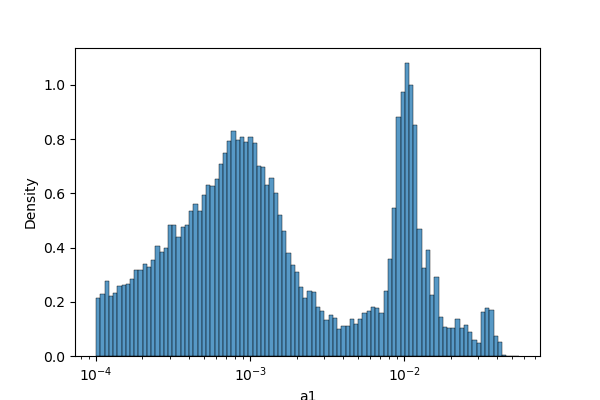

In [9]:
ss=0
df = df_tfit
keep = df[f'a{ss+1}'] > 1e-4
#
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
sns.histplot(df[keep], x=f'a{ss+1}',
             bins=100, ax=ax,
        common_bins=True, stat='density', common_norm=False,
        log_scale=True)
plt.show()

## Geo me

In [10]:
high = df_tfit.a1 > 0.007

In [11]:
df_tfit[high]

,a1,UID
29809,0.007643,1612282680000000000
29810,0.007923,1612282740000000000
29811,0.007333,1612282800000000000
29812,0.007791,1612282860000000000
29813,0.008127,1612282920000000000
...,...,...
39995,0.012858,1614520080000000000
39996,0.012653,1614520140000000000
39997,0.012827,1614520200000000000
39998,0.013044,1614520260000000000


### Match IDs

In [12]:
mid = cat_utils.match_ids(df_tfit.UID.values, df_tara.UID.values)

In [13]:
high_tara = geopandas.GeoDataFrame(df_tara.iloc[mid])

In [14]:
high_tara.geometry

utc_dt
2020-12-26 20:12:00     POINT (-11.29964 41.59486)
2020-12-26 20:13:00     POINT (-11.30090 41.59301)
2020-12-26 20:14:00     POINT (-11.30202 41.59115)
2020-12-26 20:15:00     POINT (-11.30316 41.58933)
2020-12-26 20:16:00     POINT (-11.30421 41.58752)
                                  ...             
2021-02-28 13:48:00    POINT (-75.00515 -50.50069)
2021-02-28 13:49:00    POINT (-75.00620 -50.50068)
2021-02-28 13:50:00    POINT (-75.00726 -50.50063)
2021-02-28 13:51:00    POINT (-75.00832 -50.50055)
2021-02-28 13:52:00    POINT (-75.00939 -50.50046)
Name: geometry, Length: 40000, dtype: geometry

<Axes: >

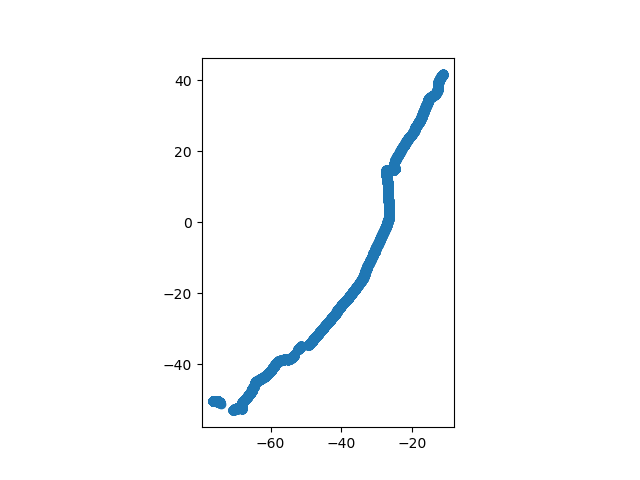

In [15]:
high_tara.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


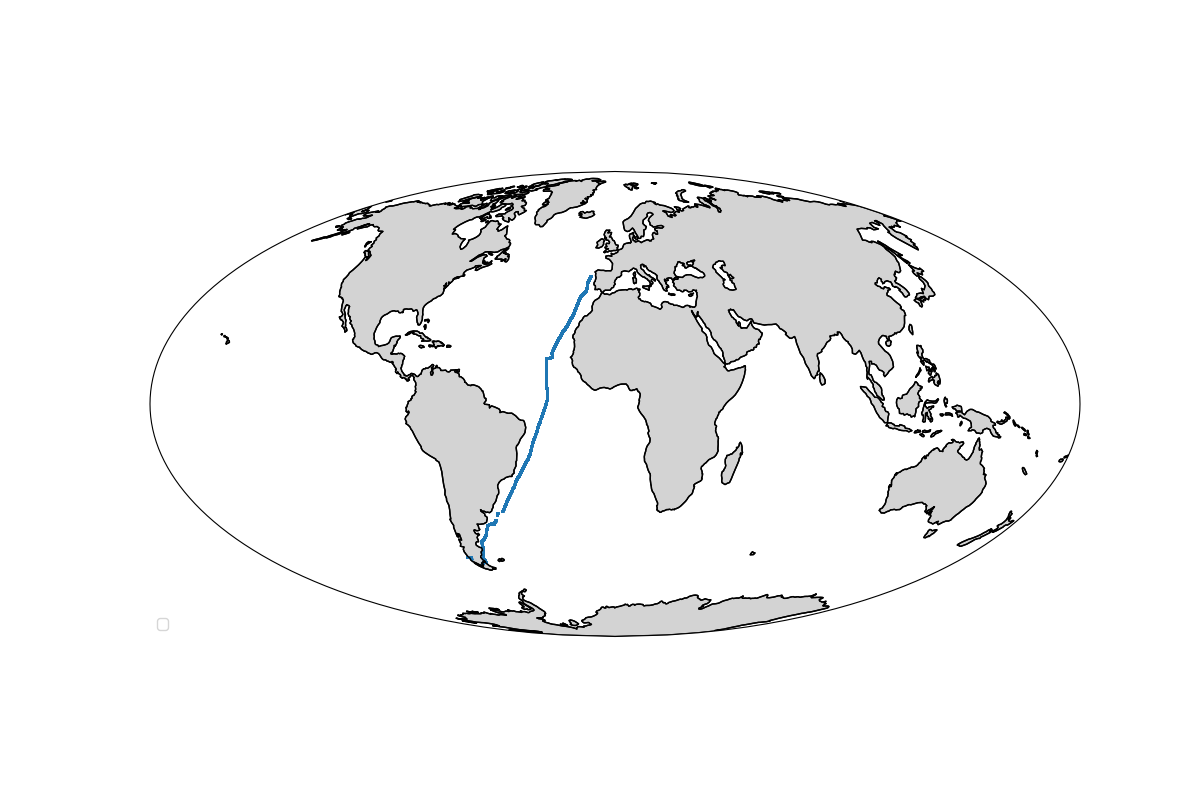

In [16]:
fig = plt.figure(figsize=(12,8))
plt.clf()

ax = plt.subplot(projection=tformM)

img = plt.scatter(x=high_tara.lon,
        y=high_tara.lat,
        #c=hp_plot[good], 
        #cmap=cm,
        #vmin=0.,
        #vmax=vmax, 
        s=1,
        transform=tformP)
                     #label=cruise)

# Coast lines
ax.coastlines(zorder=10)
ax.add_feature(cartopy.feature.LAND, 
    facecolor='lightgray', edgecolor='black')
ax.set_global()
ax.legend(loc='lower left')

plt.show()

## Other attributes

In [18]:
high_tara.Chl_lineheight

utc_dt
2020-12-26 20:12:00    0.474123
2020-12-26 20:13:00    0.457297
2020-12-26 20:14:00    0.460825
2020-12-26 20:15:00    0.445997
2020-12-26 20:16:00    0.435189
                         ...   
2021-02-28 13:48:00    3.483908
2021-02-28 13:49:00    3.481428
2021-02-28 13:50:00    3.548344
2021-02-28 13:51:00    3.580194
2021-02-28 13:52:00    3.609449
Name: Chl_lineheight, Length: 40000, dtype: float64

In [19]:
df_tara['Sample'] = 'Normal'
df_tara['Sample'].values[mid] = 'High'

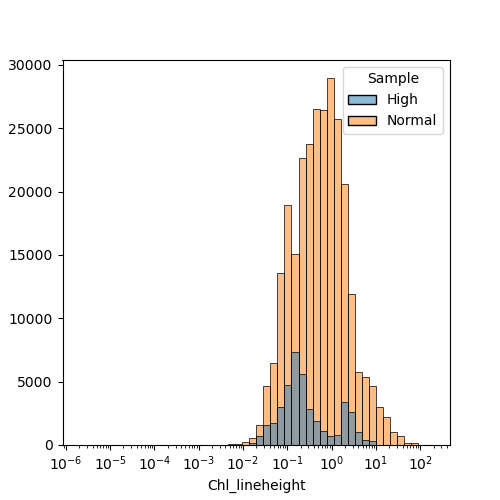

In [23]:
fig = plt.figure(figsize=(5,5))
sns.histplot(df_tara, x='Chl_lineheight', hue='Sample', bins=50,
            log_scale=True)
plt.show()